In [514]:
# Cargamos nuestras librerias
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
from tqdm.notebook import tqdm

from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.tsa.stattools as sts
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

<!-- # Simulacion -->

In [ ]:
class Fuga:
    def __init__(self, folio, fh_reg_incidente, id_reporte, fh_reporte, hr_reporte, clasificacion, tipo_falla, medio_recepcion, alcaldia, colonia, latitud, longitud, day, month, year) -> None:
        self.folio = folio
        self.fecha_registro_incidente = fh_reg_incidente
        self.id_reporte = id_reporte
        self.fecha_reporte = fh_reporte
        self.hora_reporte = hr_reporte
        self.clasificacion = clasificacion
        self.tipo_de_falla = tipo_falla
        self.medio_recepcion = medio_recepcion
        self.alcaldia_catalogo = alcaldia
        self.colonia_catalogo = colonia
        self.latitud = latitud
        self.longitud = longitud
        self.day = day
        self.month = month
        self.year = year


In [ ]:
def generar_datetime_aleatoria(year):
    # Generar un día y mes aleatorios
    month = random.randint(1, 12)
    day = random.randint(1, 28) if month == 2 else random.randint(1, 30) if month in [4, 6, 9, 11] else random.randint(1, 31)
    
    # Generar una hora, minuto y segundo aleatorios
    hour = random.randint(0, 23)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    
    # Crear la fecha y hora aleatoria
    fecha_hora_aleatoria = datetime.datetime(year, month, day, hour, minute, second)
    return fecha_hora_aleatoria

In [ ]:
year = 2024
test_extra = None
for _ in tqdm(range(10)):
    fecha_hora = generar_datetime_aleatoria(year)
    test_extra = fecha_hora
    print(fecha_hora)

print(fecha_hora.time())

In [ ]:
fecha_hora.year

In [ ]:
def run_simulation(data: pd.DataFrame, n_iterations=1000) -> pd.DataFrame:
    seed = np.random.randint(1, n_iterations)
    np.random.seed(seed)
    # Medios de recepción de los reportes
    medios_recepcion = ['DGSU',
    'Puesto de Mando Sacmex',
    'Redes Sociales (Instagram)',
    'Otros / Personal',
    'Ciudadano (Call Center)',
    'Redes Sociales (Facebook)',
    'Campamento o Alcaldía',
    'Secretaría de Seguridad Ciudadana (SSC)',
    'SUAC',
    'Redes Sociales (Twitter)',
    'Locatel folio',
    'C-5 (Protección Civil, Bomberos, Locatel)',
    'Medios de Comunicación',
    'Puesto de Mando',
    'Servicio de Atención Ciudadana',
    'Personal Directivo de SACMEX',
    'Jefatura de Gobierno/Base Cúspide']
    results = []
    for _ in tqdm(range(n_iterations)):
        # Seleccionar filas aleatorias del DataFrame
        sample = data.sample(n=1, random_state=np.random.randint(1, n_iterations))

        # Crear un nuevo registro con valores aleatorios
        fh_reporte = generar_datetime_aleatoria(year)
        new_record = Fuga(
            folio=f"I-{np.random.randint(20230101, 20231231)}-{np.random.randint(1000, 9999)}",
            fh_reg_incidente=fh_reporte + datetime.timedelta(days=np.random.randint(1, 10)),
            id_reporte=f"R-{np.random.randint(20230101, 20231231)}-{np.random.randint(1000, 9999)}",
            fh_reporte=fh_reporte.date(),
            hr_reporte=fh_reporte.time(),
            clasificacion=np.random.choice(['Agua Tratada', 'Agua Potable']),
            tipo_falla='Fuga',
            medio_recepcion=np.random.choice(medios_recepcion),
            alcaldia=np.random.choice(data[data['alcaldia_catalogo'] != 'NA']['alcaldia_catalogo'].unique()),
            colonia=np.random.choice(data[data['colonia_catalogo'] != 'NA']['colonia_catalogo'].unique()),
            latitud=np.random.uniform(19.2, 19.5),
            longitud=np.random.uniform(-99.3, -99.0),
            day=fh_reporte.day,
            month=fh_reporte.month,
            year=fh_reporte.year
        )
        results.append(new_record.__dict__)
    
    return pd.DataFrame(results)

# Simulanción Montecarlo

In [ ]:
data = pl.read_parquet("../DATASETS/fugas.parquet.gzip")

In [ ]:
data.head()

In [ ]:
# Total filas y columnas cargadas
f'Total registros: {data.shape[0]}, Total columnas: {data.shape[1]}'

In [ ]:
# Simulando 10000
simulated_data = run_simulation(data=data.to_pandas(), n_iterations=10000)

In [ ]:
simulated_data

In [ ]:
simulated_data[['fecha_registro_incidente', 'day', 'month', 'year']].hist(figsize=(12, 8))
plt.show()

In [ ]:
sns.set_theme()

g = simulated_data['month'].hist(bins=10)
g.set(
    title="Histograma distribución de datos por mes".upper(),
    xlabel="MES"
)
plt.show()

In [ ]:
sns.countplot(data=simulated_data, x='alcaldia_catalogo')
plt.show()

In [ ]:
simulated_data['alcaldia_catalogo'].value_counts(sort=True, ascending=True).iloc[:10].plot(kind='barh')


In [ ]:
g = sns.countplot(data=simulated_data, x='month')
g.set(
    xlabel="Mes",
    ylabel="Total",
    title="Histograma datos simulados por mes"
)
# axes[1,0].set_title('Distribución por Mes')
# axes[1,0].set_xlabel('Mes')
# axes[1,0].set_ylabel('Cantidad de Incidentes')
plt.show()

# Forecasting

In [ ]:
dfp = pl.read_parquet("../DATASETS/fugas.parquet.gzip")

In [ ]:
dfp.head()

In [ ]:
df = dfp.with_columns(
    alcaldia_catalogo = pl.col("alcaldia_catalogo").str.to_uppercase(),
    colonia_catalogo = pl.col("colonia_catalogo").str.to_uppercase(),
    day=pl.col("fecha_reporte").dt.day(),
    month=pl.col("fecha_reporte").dt.month(),
    year=pl.col("fecha_reporte").dt.year()
)

In [ ]:
df.sample(5)

In [180]:
df_por_fecha = df \
    .filter(pl.col('alcaldia_catalogo') != 'NA') \
    .group_by([pl.col("fecha_reporte").dt.date(), pl.col("alcaldia_catalogo")]) \
    .agg(total_fugas=(pl.col('tipo_de_falla').count())) \
    .sort(by=['fecha_reporte']) \
    .to_pandas()

In [182]:
df_por_fecha.head()

,fecha_reporte,alcaldia_catalogo,total_fugas
0,2021-01-01,GUSTAVO A. MADERO,1
1,2021-01-01,CUAUHTEMOC,2
2,2021-01-01,AZCAPOTZALCO,2
3,2021-01-01,COYOACAN,2
4,2021-01-01,TLALPAN,2


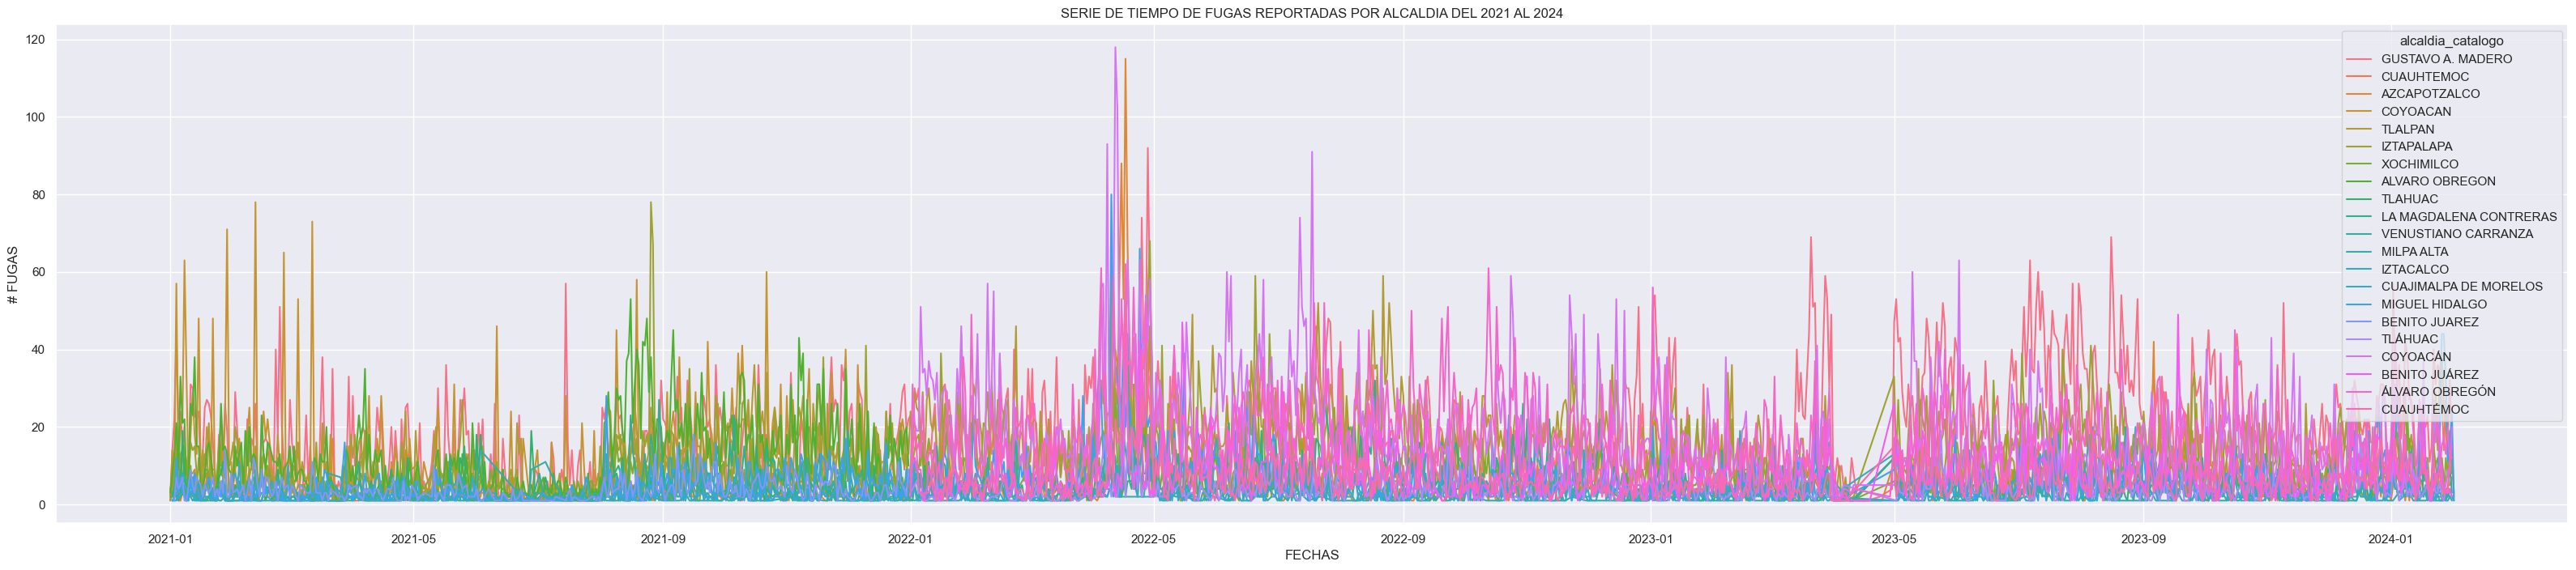

In [206]:
fig, ax = plt.subplots(figsize=(40, 8))

g = sns.lineplot(df_por_fecha, x='fecha_reporte', y='total_fugas', hue='alcaldia_catalogo', ax=ax)
sns.move_legend(ax, "upper right")

g.set(
    xlabel="Fechas".upper(),
    ylabel="# Fugas".upper(),
    title="serie de tiempo de fugas reportadas por alcaldia del 2021 al 2024".upper()
)
plt.show()

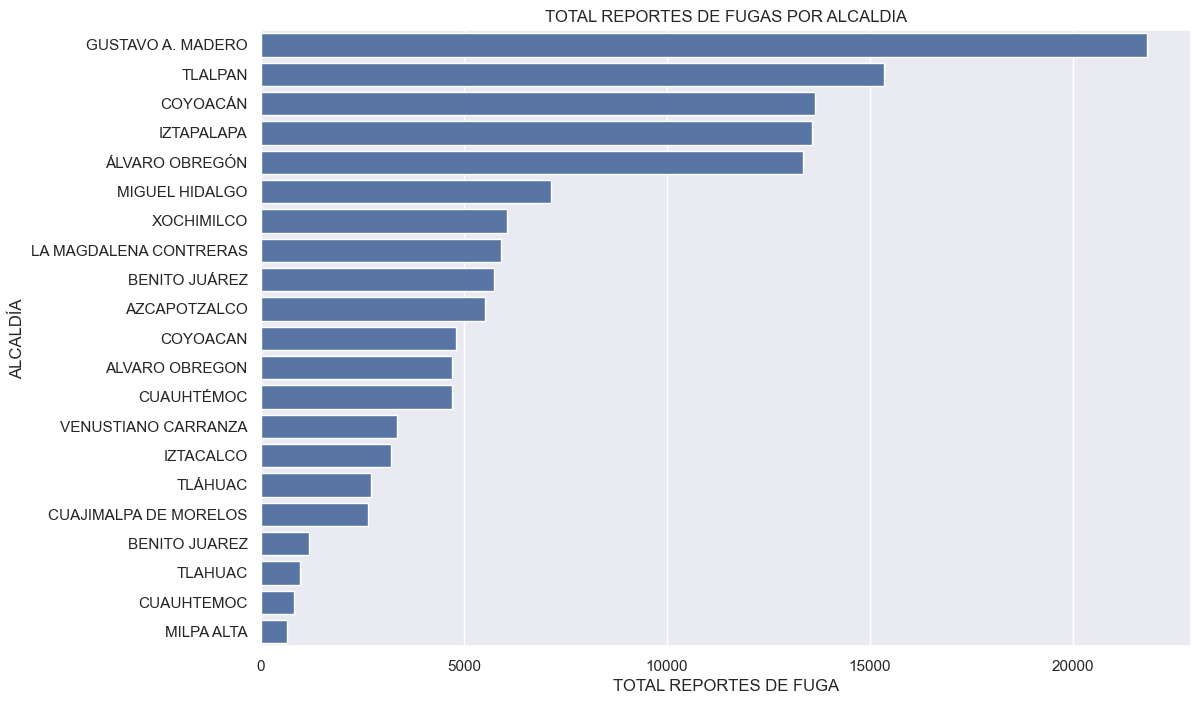

In [205]:
alcaldias_reportes = df_por_fecha.groupby('alcaldia_catalogo', as_index=False)['total_fugas'].sum().sort_values('total_fugas', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

g = sns.barplot(alcaldias_reportes, 
            y='alcaldia_catalogo', 
            x='total_fugas', 
            orient='h',
            ax=ax)

g.set(xlabel="Total reportes de fuga".upper(), ylabel="alcaldía".upper(), title="Total reportes de fugas por alcaldia".upper())

plt.show()

In [444]:
df_gam = df_por_fecha[(df_por_fecha.alcaldia_catalogo == "GUSTAVO A. MADERO") & (df_por_fecha.fecha_reporte.dt.year != 2024)]
df_tla = df_por_fecha[(df_por_fecha.alcaldia_catalogo == "TLALPAN") & (df_por_fecha.fecha_reporte.dt.year != 2024)]
df_coy = df_por_fecha[(df_por_fecha.alcaldia_catalogo == "COYOACAN") & (df_por_fecha.fecha_reporte.dt.year != 2024)]

In [432]:
df_gam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1075 entries, 0 to 15040
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha_reporte      1075 non-null   datetime64[ms]
 1   alcaldia_catalogo  1075 non-null   object        
 2   total_fugas        1075 non-null   uint32        
dtypes: datetime64[ms](1), object(1), uint32(1)
memory usage: 29.4+ KB


In [220]:
df_coy.info()
df_tla.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, 3 to 4721
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha_reporte      350 non-null    datetime64[ms]
 1   alcaldia_catalogo  350 non-null    object        
 2   total_fugas        350 non-null    uint32        
dtypes: datetime64[ms](1), object(1), uint32(1)
memory usage: 9.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1060 entries, 4 to 15039
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha_reporte      1060 non-null   datetime64[ms]
 1   alcaldia_catalogo  1060 non-null   object        
 2   total_fugas        1060 non-null   uint32        
dtypes: datetime64[ms](1), object(1), uint32(1)
memory usage: 29.0+ KB


In [232]:

df_coy.set_index("fecha_reporte", inplace=True)
df_tla.set_index("fecha_reporte", inplace=True)

In [445]:
df_gam.set_index("fecha_reporte", inplace=True)
df_gam.sort_index(inplace=True)

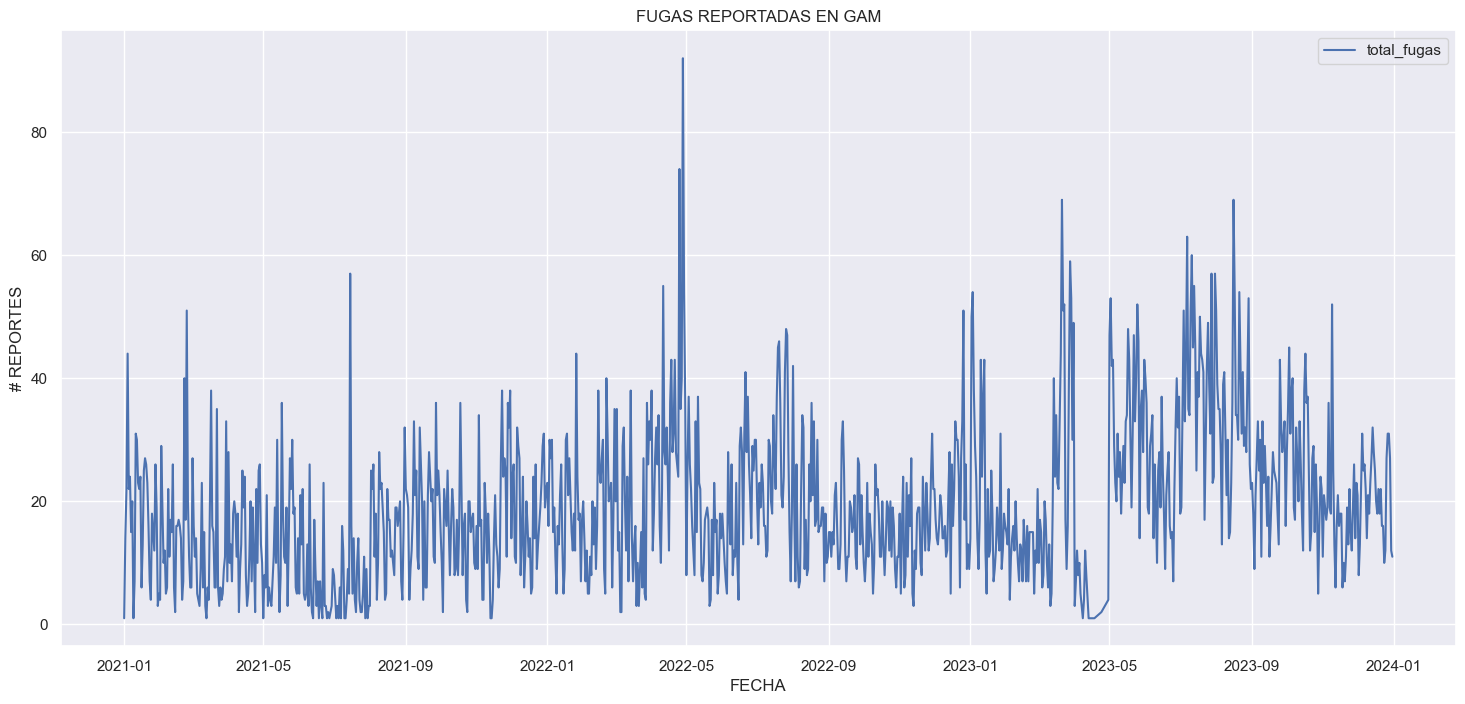

In [446]:
fig, ax = plt.subplots(figsize=(18, 8))
g = sns.lineplot(df_gam, ax=ax)
# df_gam.iloc[0:350].plot(figsize=(30,10), title='Fugas reportadas'.upper())
g.set(
    xlabel="fecha".upper(),
    ylabel="# Reportes".upper(),
    title='Fugas reportadas en GAM'.upper()
)
plt.show()

In [ ]:
df_coy.iloc[0:350].plot(figsize=(30,10),title='spx prices')
plt.show()

In [ ]:
fig, ax = plt.subplots()

df_gam.iloc[0:350].plot(ax=ax, figsize=(30,10))
df_coy.iloc[0:350].plot(ax=ax, figsize=(30,10))
plt.show()

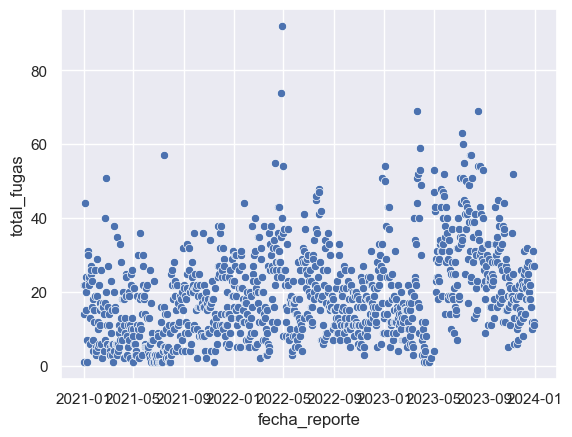

In [236]:
sns.scatterplot(df_gam, x="fecha_reporte", y="total_fugas")
plt.show()

In [237]:
df_por_fecha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15500 entries, 0 to 15499
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha_reporte      15500 non-null  datetime64[ms]
 1   alcaldia_catalogo  15500 non-null  object        
 2   total_fugas        15500 non-null  uint32        
dtypes: datetime64[ms](1), object(1), uint32(1)
memory usage: 302.9+ KB


In [238]:
df_gam.sort_index(inplace=True)

# Ruido blanco

In [241]:
df_gam.head()

,alcaldia_catalogo,total_fugas,wn_total_fugas
fecha_reporte,,,
2021-01-01,GUSTAVO A. MADERO,1,13.347292
2021-01-02,GUSTAVO A. MADERO,14,5.286217
2021-01-03,GUSTAVO A. MADERO,22,27.474306
2021-01-04,GUSTAVO A. MADERO,44,31.127982
2021-01-05,GUSTAVO A. MADERO,22,29.306452


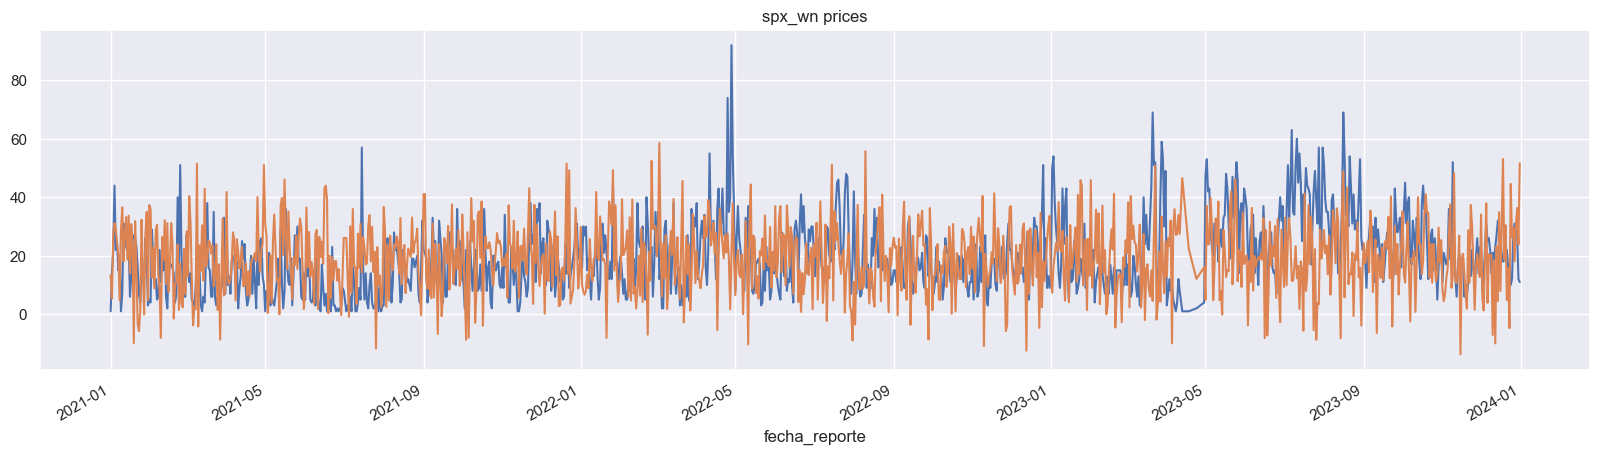

In [242]:
fig, ax = plt.subplots()

df_gam.total_fugas.plot(figsize=(20,5),title='spx prices')
df_gam.wn_total_fugas.plot(figsize=(20,5),title='spx_wn prices')
plt.show()

In [447]:
# Probar estacionariedad
result = sts.adfuller(df_gam.total_fugas)
print('Estadístico ADF:', result[0])
print('p-value:', result[1])
print('Valores críticos:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Estadístico ADF: -3.9685010941659864
p-value: 0.0015847333988030007
Valores críticos:
	1%: -3.436581300425998
	5%: -2.8642912936257905
	10%: -2.5682348955818357


In [448]:
# df_gam.set_index("fecha_reporte", inplace=True)
df_gam = df_gam.asfreq("d")
df_gam = df_gam.fillna(method='ffill')

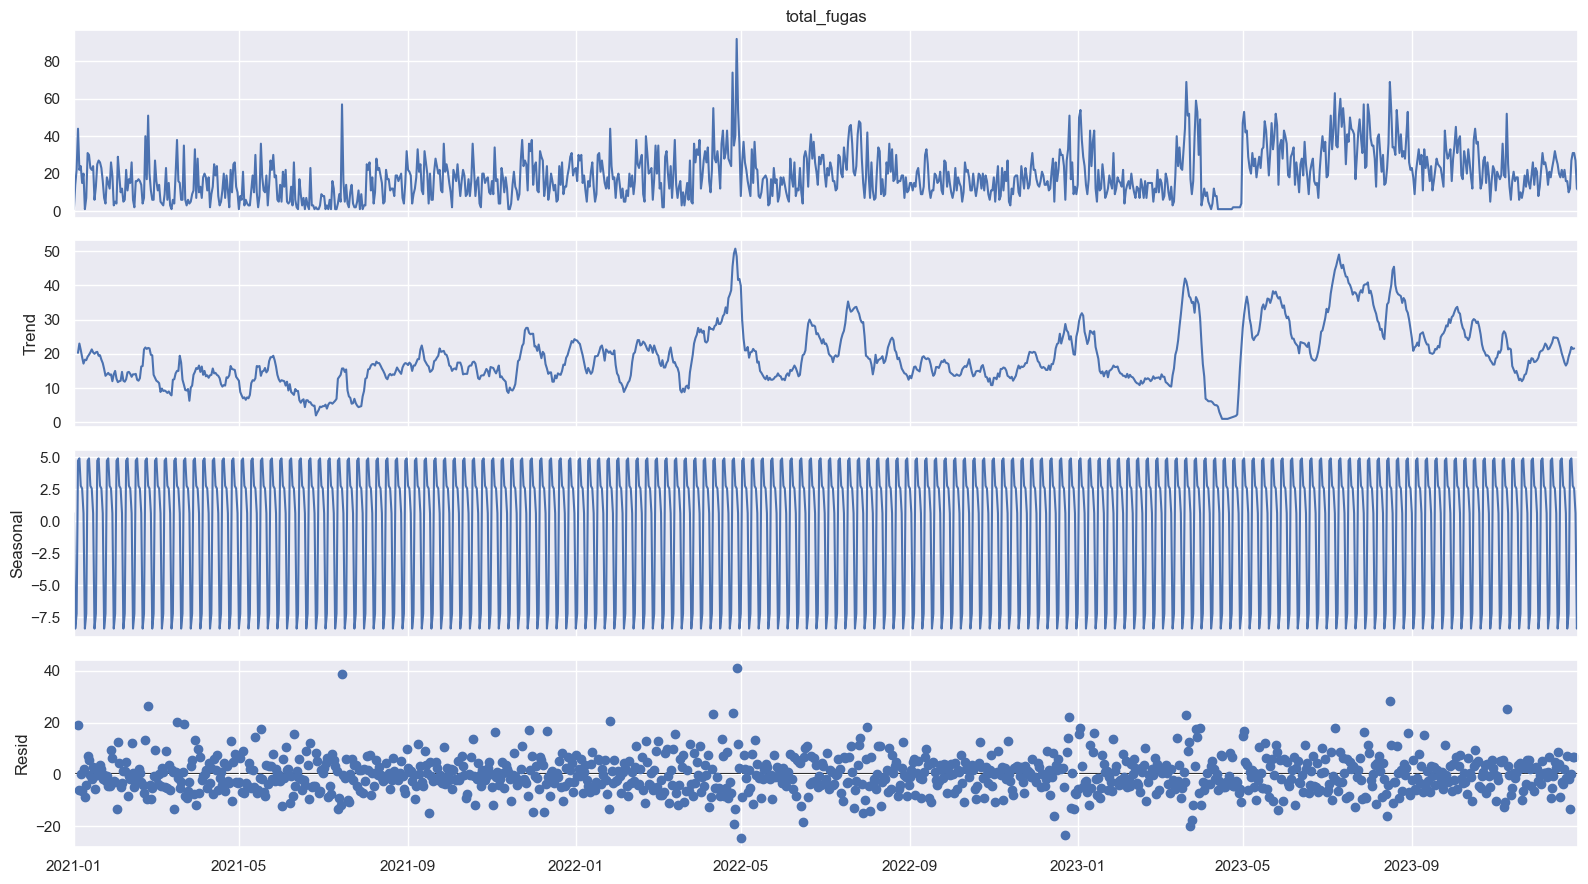

In [449]:
decompose_result_add = seasonal_decompose(df_gam.total_fugas, model='additive')
fig = decompose_result_add.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

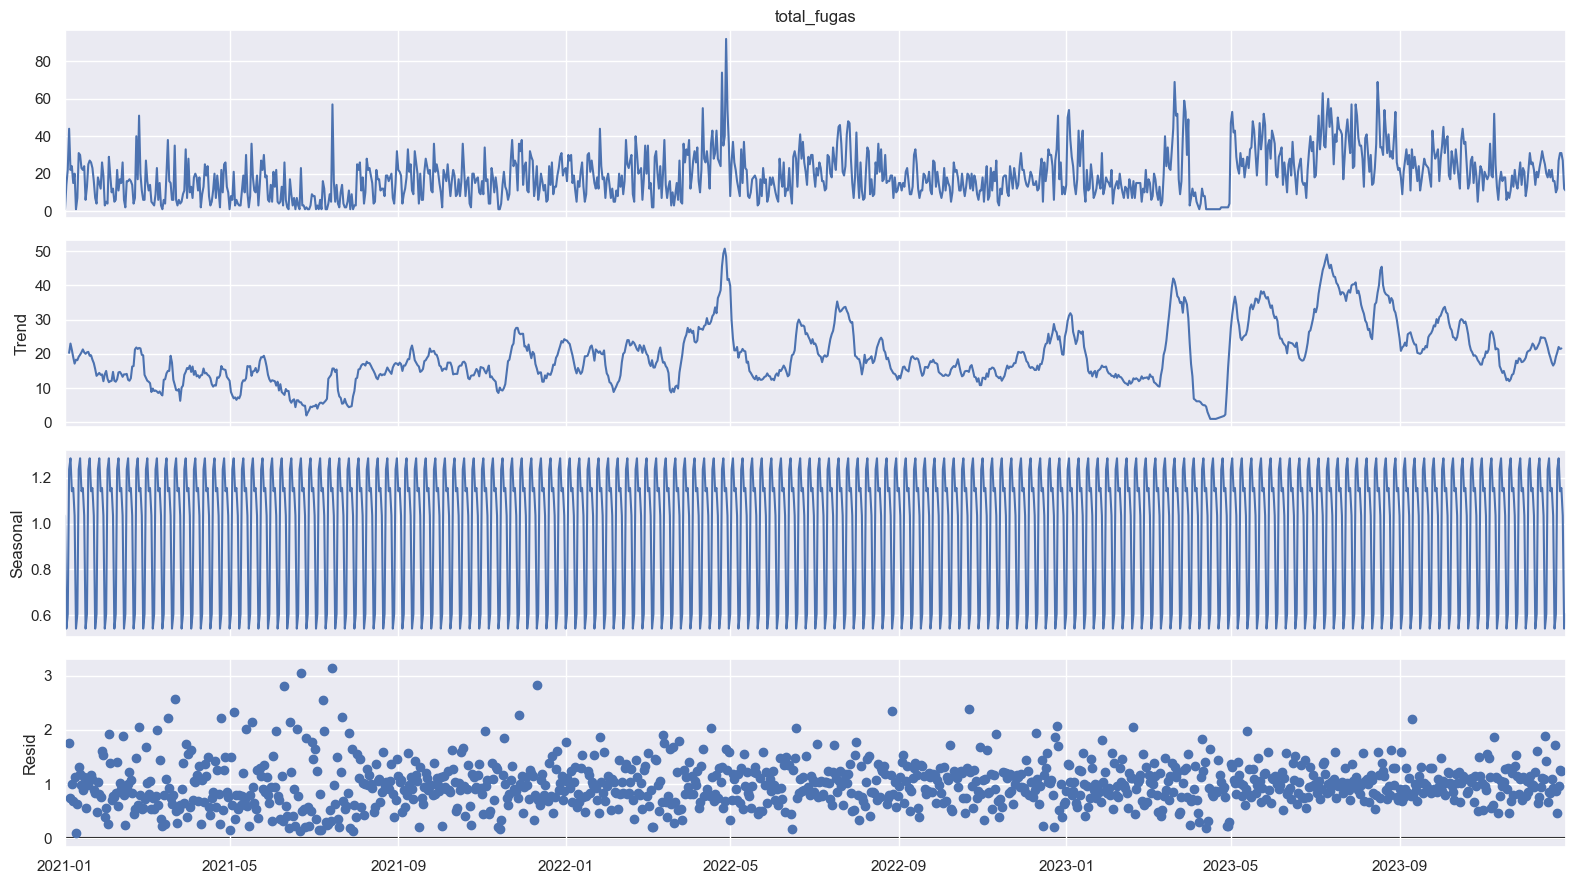

In [450]:
decompose_result_mult = seasonal_decompose(df_gam.total_fugas, model='multiplicative')
fig = decompose_result_mult.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

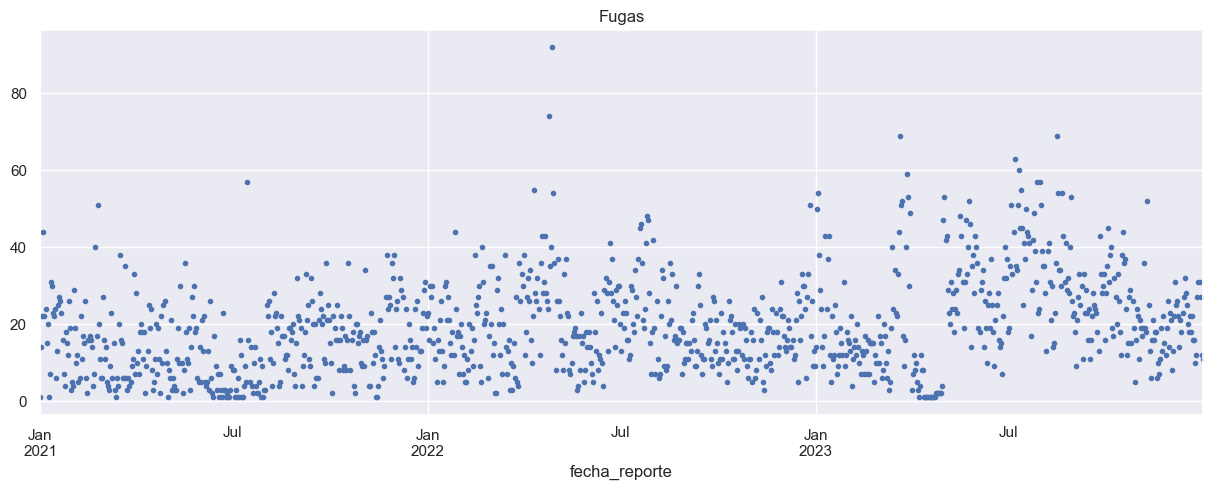

In [263]:
df_gam.total_fugas.plot(style='.',
        figsize=(15, 5),
        title='Fugas')
plt.show()

In [ ]:
# Set the frequency of the date time index as Monthly start as indicated by the data
df_gam_monthly = df_gam.asfreq("ME")

In [ ]:
df_gam_monthly

In [ ]:
# Set the value of Alpha and define m (Time Period)
m = 12
alpha = 1/(2*m)

In [ ]:
df_gam_monthly.loc[:, 'total_fugas_1'] = SimpleExpSmoothing(df_gam_monthly.total_fugas).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
df_gam_monthly[['total_fugas','total_fugas_1']].plot(title='Holt Winters Single Exponential Smoothing')
plt.show()

In [ ]:
df_gam_monthly.loc[:, 'total_fugas_ADD'] = ExponentialSmoothing(df_gam_monthly.total_fugas, trend='add').fit().fittedvalues
df_gam_monthly.loc[:, 'total_fugas_MUL'] = ExponentialSmoothing(df_gam_monthly.total_fugas, trend='mul').fit().fittedvalues
fig = df_gam_monthly[['total_fugas','total_fugas_ADD','total_fugas_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend', figsize=(16, 9))
# fig.set_size_inches((16, 9))
# Tight layout to realign things
# fig.tight_layout()
plt.show()

In [ ]:
dfp['passengersS2_ADD'] = ExponentialSmoothing(dfp.Passengers, trend='add').fit().fittedvalues
dfp['passengersS2_MUL'] = ExponentialSmoothing(dfp.Passengers, trend='mul').fit().fittedvalues
dfp[['Passengers','passengersS2_ADD','passengersS2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend')

In [ ]:
df_gam_monthly.loc[:, 'PTJS3_ADD'] = ExponentialSmoothing(df_gam_monthly.total_fugas, trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues
df_gam_monthly.loc[:, 'PTJS3_MUL'] = ExponentialSmoothing(df_gam_monthly.total_fugas, trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues
df_gam_monthly[['total_fugas','PTJS3_ADD','PTJS3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Trend', figsize=(19, 10))
plt.show()

In [ ]:
size = int(len(df_gam_monthly)*0.8)
size

In [ ]:
# Split into train and test set
train_des = df_gam_monthly[:size]
test_des = df_gam_monthly[size:]

In [ ]:
fitted_model = ExponentialSmoothing(train_des['total_fugas'], trend='add', seasonal='mul', seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(18)
train_des['total_fugas'].plot(legend=True,label='TRAIN')
test_des['total_fugas'].plot(legend=True,label='TEST',figsize=(6,4))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')

# Forecasting

In [451]:
size = int(len(df_gam)*0.8)
train_des = df_gam[:size] # 80% datos entrenamiento
test_des = df_gam[size:] # 20% datos de prueba

In [452]:
train_des.shape

(876, 2)

In [453]:
test_des.shape

(219, 2)

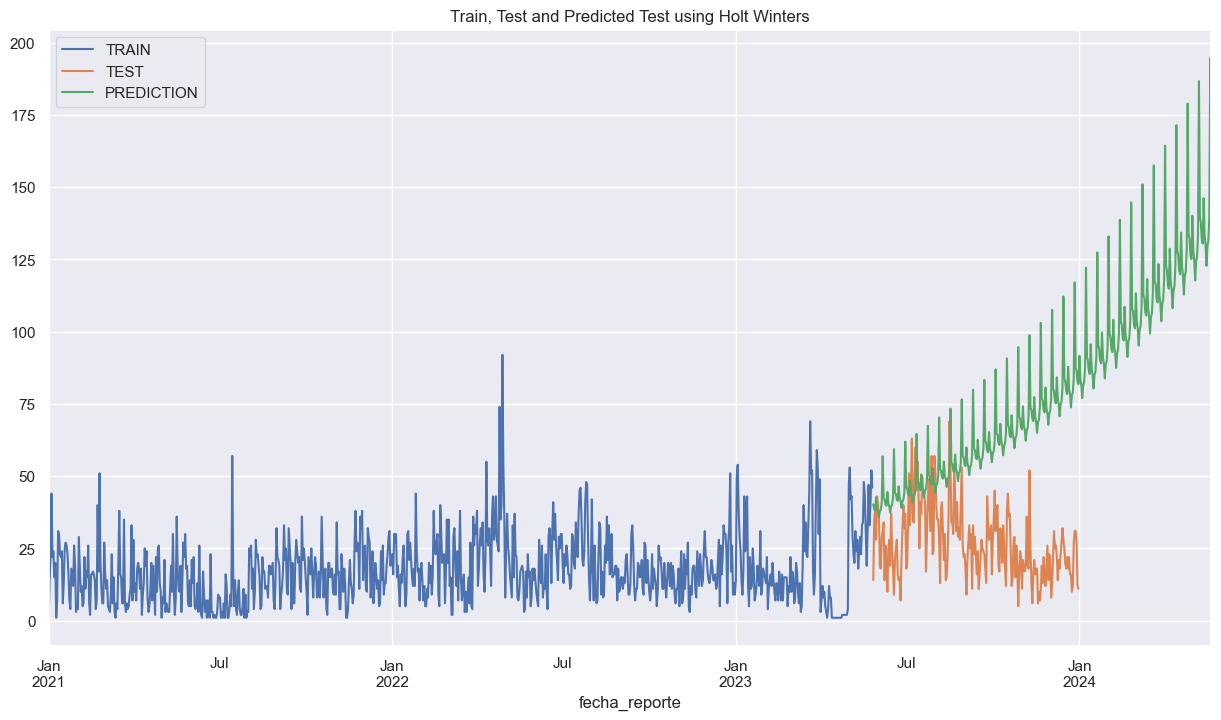

In [455]:
# Suavizado exponencial
fig, ax = plt.subplots(figsize=(15,8))
fitted_model = ExponentialSmoothing(train_des['total_fugas'], trend='mul', seasonal='mul', seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(360)
train_des['total_fugas'].plot(legend=True, label='TRAIN', ax=ax)
test_des['total_fugas'].plot(legend=True,label='TEST', ax=ax)
test_predictions.plot(legend=True,label='PREDICTION', ax=ax)
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()

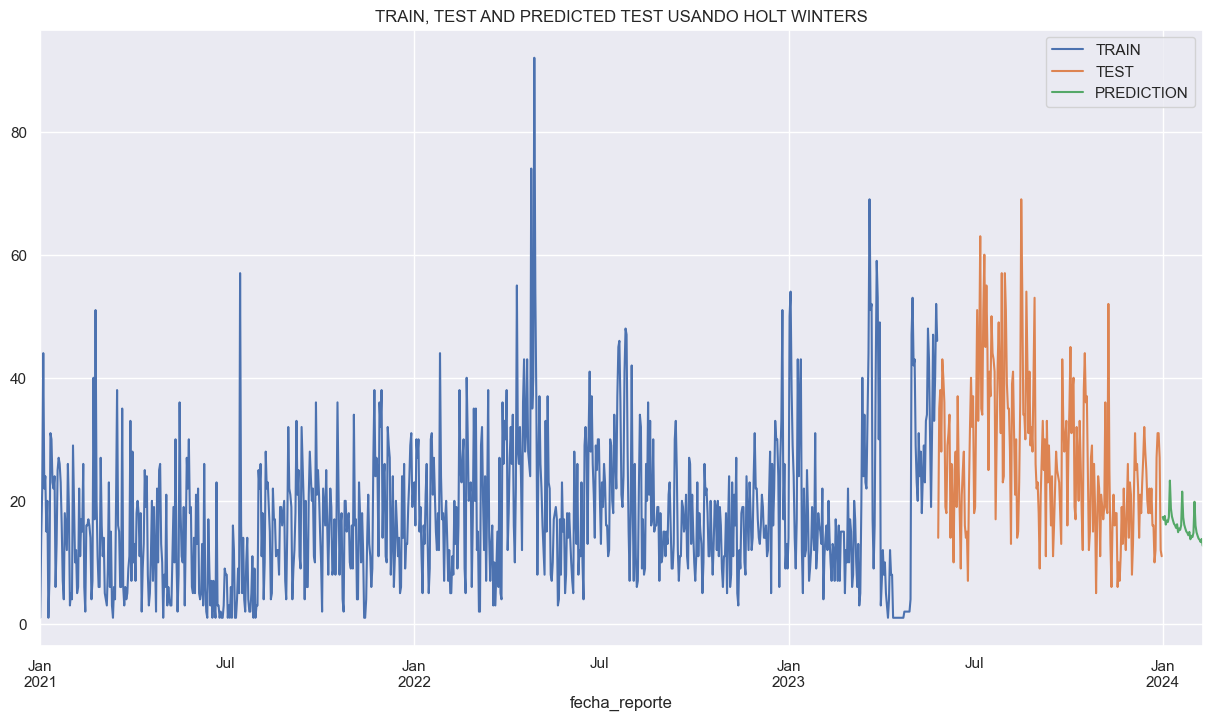

In [456]:
# Suavizado exponencial
fig, ax = plt.subplots(figsize=(15,8))
fitted_model = ExponentialSmoothing(df_gam['total_fugas'], trend='mul', seasonal='mul', seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(40)
train_des['total_fugas'].plot(legend=True, label='TRAIN', ax=ax)
test_des['total_fugas'].plot(legend=True,label='TEST', ax=ax)
test_predictions.plot(legend=True,label='PREDICTION', ax=ax)
plt.title('Train, Test and Predicted Test usando Holt Winters'.upper())
plt.show()

In [457]:
test_predictions

2024-01-01    17.367817
2024-01-02    16.908447
2024-01-03    17.547949
2024-01-04    16.141899
2024-01-05    16.800822
2024-01-06    16.558336
2024-01-07    17.368035
2024-01-08    23.293128
2024-01-09    18.757619
2024-01-10    17.462994
2024-01-11    16.826033
2024-01-12    16.272044
2024-01-13    16.032702
2024-01-14    15.608645
2024-01-15    16.198986
2024-01-16    14.901024
2024-01-17    15.509293
2024-01-18    15.285448
2024-01-19    16.032903
2024-01-20    21.502516
2024-01-21    17.315665
2024-01-22    16.120562
2024-01-23    15.532566
2024-01-24    15.021164
2024-01-25    14.800221
2024-01-26    14.408762
2024-01-27    14.953722
2024-01-28    13.755538
2024-01-29    14.317048
2024-01-30    14.110410
2024-01-31    14.800407
2024-02-01    19.849555
2024-02-02    15.984559
2024-02-03    14.881327
2024-02-04    14.338532
2024-02-05    13.866443
2024-02-06    13.662484
2024-02-07    13.301118
2024-02-08    13.804186
2024-02-09    12.698109
Freq: D, dtype: float64

In [458]:
df_gam_2024 = df_por_fecha[(df_por_fecha.alcaldia_catalogo == "GUSTAVO A. MADERO") & (df_por_fecha.fecha_reporte.dt.year == 2024)]

In [459]:
df_gam_2024 = df_gam_2024.set_index('fecha_reporte')
df_gam_2024 = df_gam_2024.asfreq("d")

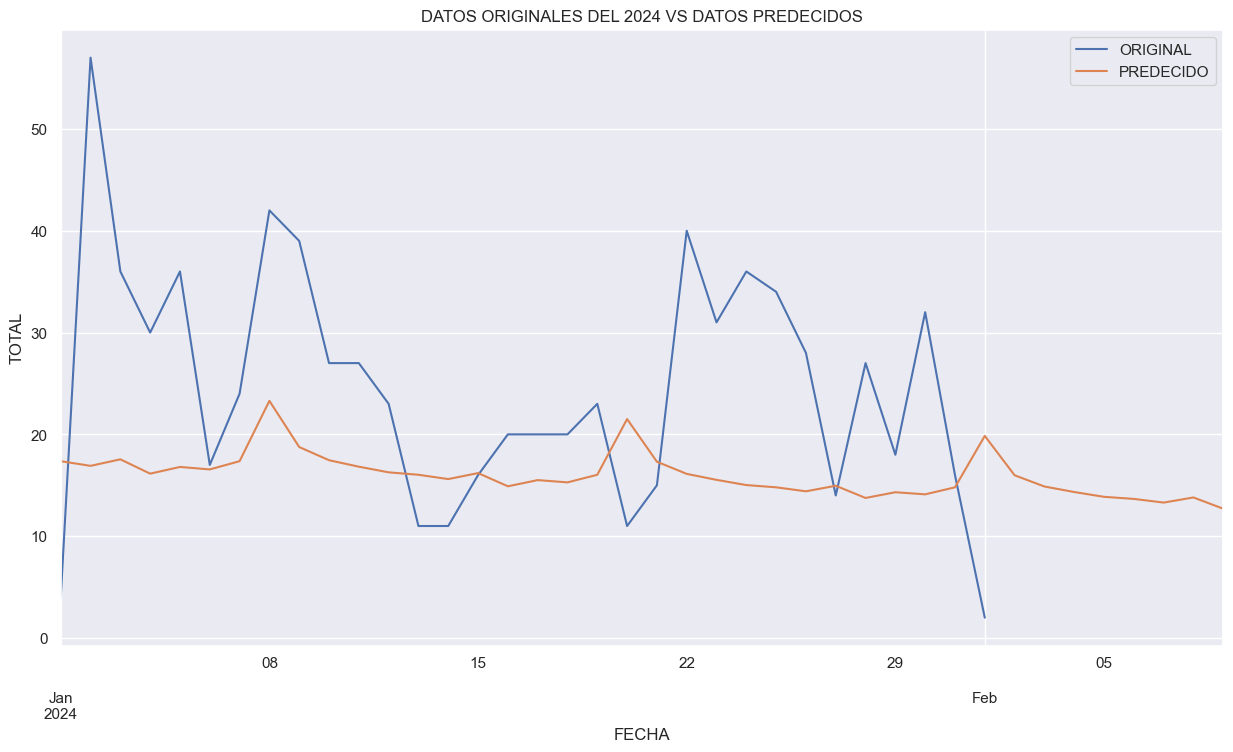

In [460]:
fig, ax = plt.subplots(figsize=(15,8))
df_gam_2024['total_fugas'].plot(legend=True, label='ORIGINAL', ax=ax)
test_predictions.plot(legend=True, label='PREDECIDO', ax=ax)
plt.title('datos originales del 2024 vs datos predecidos'.upper())
ax.set_xlabel("FECHA")
ax.set_ylabel("TOTAL")
plt.show()

In [461]:
df_gam_2024.loc['2024-01-01':'2024-01-31'].shape, test_predictions.loc['2024-01-01':'2024-01-31'].shape

((31, 2), (31,))

In [462]:
rmse = root_mean_squared_error(df_gam_2024.loc['2024-01-01':'2024-01-31']['total_fugas'], test_predictions.loc['2024-01-01':'2024-01-31']).round(2)

In [463]:
mape = mean_absolute_percentage_error(df_gam_2024.loc['2024-01-01':'2024-01-31']['total_fugas'], test_predictions.loc['2024-01-01':'2024-01-31']).round(2) * 100

In [464]:
pl.DataFrame({'RMSE': rmse, 'MAPE': mape})

RMSE,MAPE
f64,f64
14.28,48.0


In [421]:
 # Encontrar mejores parámetros automáticamente para ARIMA
auto_model = auto_arima(train_des['total_fugas'], seasonal=False, stepwise=True,
                           suppress_warnings=True, error_action="ignore")

In [425]:
# Crear y entrenar modelo ARIMA
order = auto_model.order
arima_model = ARIMA(train_des['total_fugas'], order=order)
arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            total_fugas   No. Observations:                  876
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3261.611
Date:                Sun, 17 Nov 2024   AIC                           6529.221
Time:                        22:43:21   BIC                           6543.544
Sample:                    01-01-2021   HQIC                          6534.700
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3287      0.035      9.262      0.000       0.259       0.398
ma.L1         -0.8960      0.016    -55.496      0.000      -0.928      -0.864
sigma2       101.0931      3.099     32.626      0.000      95.020     107.166
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               435.71
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.99
Prob(H) (two-sided):                  0.61   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [427]:
# Crear y entrenar modelo SARIMAX (con componente estacional)
sarimax_model = SARIMAX(train_des['total_fugas'], 
                        order=order,
                        seasonal_order=(1, 1, 1, 12))  # Ajustar según estacionalidad
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        total_fugas   No. Observations:                  876
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3242.044
Date:                            Sun, 17 Nov 2024   AIC                           6494.088
Time:                                    22:43:46   BIC                           6517.890
Sample:                                01-01-2021   HQIC                          6503.199
                                     - 05-26-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2994      0.038      7.798      0.000       0.224       0.375
ma.L1         -0.8767      0.019    -46.787      0.000      -0.913      -0.840
ar.S.L12      -0.1086      0.034     -3.148      0.002      -0.176      -0.041
ma.S.L12      -0.9705      0.020    -48.221      0.000      -1.010      -0.931
sigma2       102.6704      3.397     30.223      0.000      96.012     109.329
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               322.06
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.85
Prob(H) (two-sided):                  0.58   Kurtosis:                         5.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

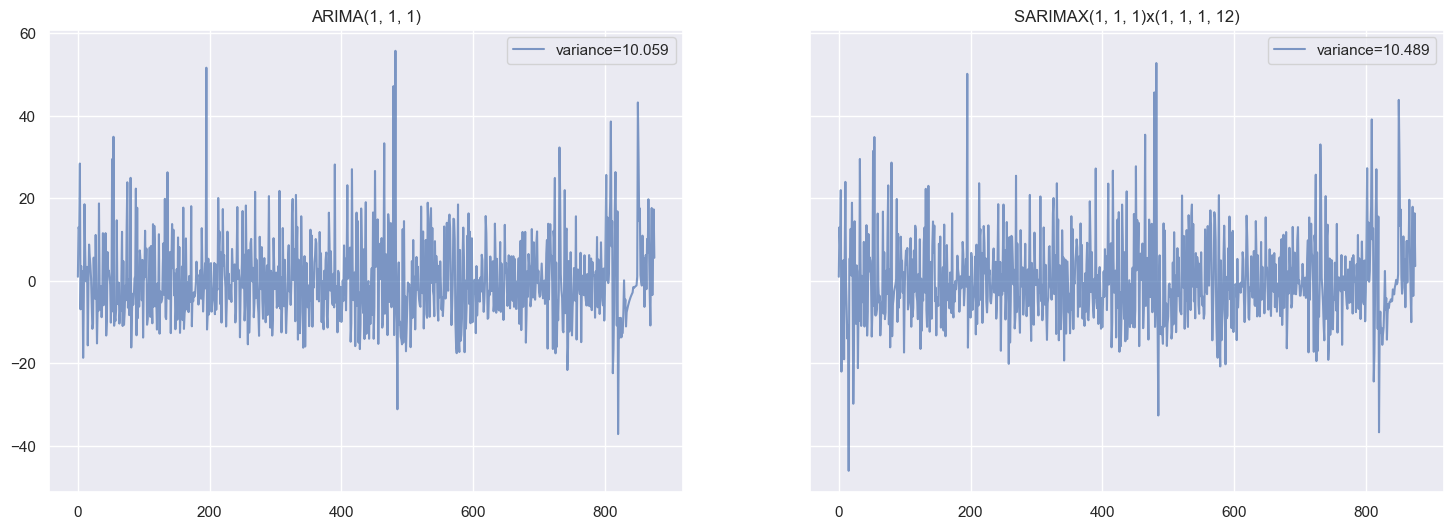

In [466]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(18, 6))
ax[0].plot(arima_fit.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(arima_fit.resid.values)));
# ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(1, 1, 1)");
ax[0].legend();
ax[1].plot(sarimax_fit.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(sarimax_fit.resid.values)));
# ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("SARIMAX(1, 1, 1)x(1, 1, 1, 12)");
ax[1].legend();

plt.show()

In [471]:
# Realizar predicciones
arima_pred = arima_fit.forecast(len(test_des['total_fugas']))
sarimax_pred = sarimax_fit.forecast(len(test_des['total_fugas']))
metricas = []
# Calcular métricas
metricas.append({
    "Model": "ARIMA",
    "MSE": mean_squared_error(test_des['total_fugas'], arima_pred).round(2),
    "MAE": mean_absolute_error(test_des['total_fugas'], arima_pred).round(2),
    "RMSE": root_mean_squared_error(test_des['total_fugas'], arima_pred).round(2),
    "MAPE": mean_absolute_percentage_error(test_des['total_fugas'], arima_pred).round(2)
})

metricas.append({
    "Model": "SARIMAX",
    "MSE": mean_squared_error(test_des['total_fugas'], sarimax_pred).round(2),
    "MAE": mean_absolute_error(test_des['total_fugas'], sarimax_pred).round(2),
    "RMSE": root_mean_squared_error(test_des['total_fugas'], sarimax_pred).round(2),
    "MAPE": mean_absolute_percentage_error(test_des['total_fugas'], sarimax_pred).round(2)
})

pd.DataFrame(metricas)

,Model,MSE,MAE,RMSE,MAPE
0,ARIMA,223.72,12.74,14.96,0.76
1,SARIMAX,384.39,16.93,19.61,1.01


In [472]:
metricas

[{'Model': 'ARIMA', 'MSE': 223.72, 'MAE': 12.74, 'RMSE': 14.96, 'MAPE': 0.76},
 {'Model': 'SARIMAX',
  'MSE': 384.39,
  'MAE': 16.93,
  'RMSE': 19.61,
  'MAPE': 1.01}]

In [506]:
 # Predecir 12 meses hacia adelante
arima_forecast = arima_fit.forecast(steps=60)
sarimax_forecast = sarimax_fit.forecast(steps=60)

# Crear fechas para 2024
future_dates = pd.date_range(start='2024-01-01', periods=60, freq='d')

# Crear DataFrame con predicciones
predictions = pd.DataFrame({
    'Fecha': future_dates,
    'ARIMA': arima_forecast,
    'SARIMAX': sarimax_forecast
}).set_index('Fecha')

In [508]:
predictions.head()

,ARIMA,SARIMAX
Fecha,,
2024-01-01,39.018776,40.487914
2024-01-02,36.723818,37.883923
2024-01-03,35.969389,35.578679
2024-01-04,35.721384,37.575812
2024-01-05,35.639856,36.793734


In [509]:
predictions = predictions.asfreq('d')

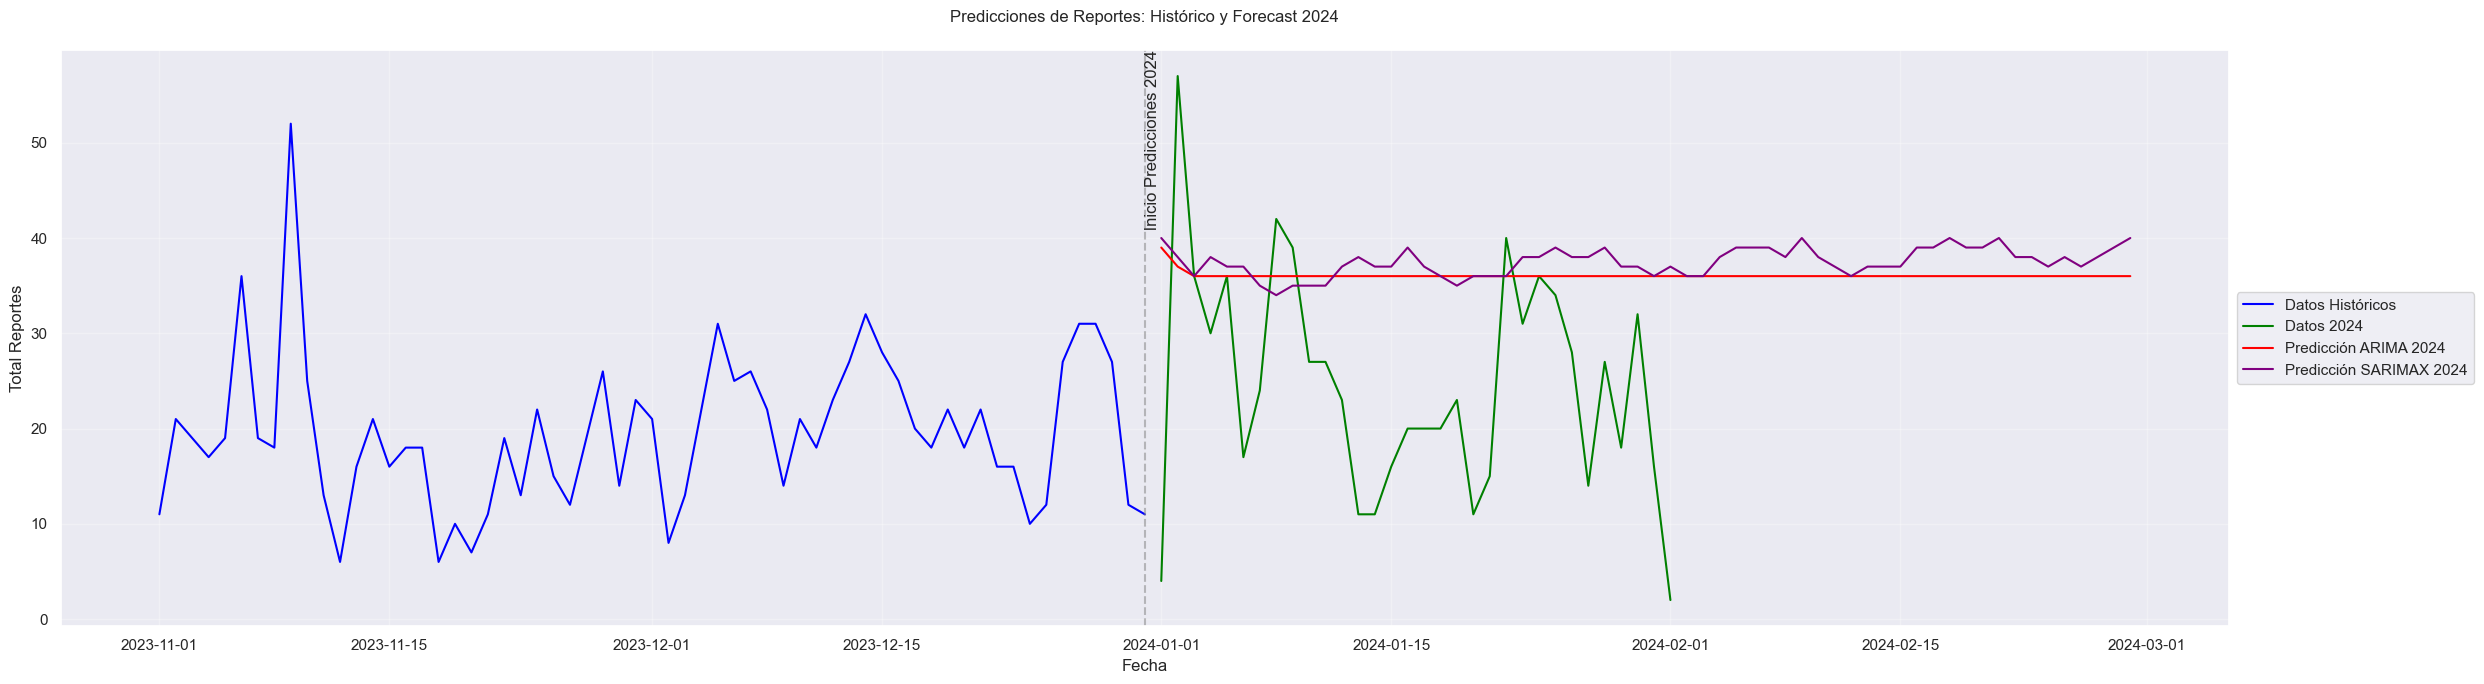

In [515]:
plt.figure(figsize=(25, 7))
    
# Datos históricos
plt.plot(df_gam.index[(df_gam.index.year == 2023) & (df_gam.index.month > 10)], df_gam.loc[(df_gam.index.year == 2023) & (df_gam.index.month > 10), 'total_fugas'], label='Datos Históricos', color='blue')

# Datos del mes de enero 2024
plt.plot(df_gam_2024.index, df_gam_2024['total_fugas'], label='Datos 2024', color='green')

# Predicciones 2024
plt.plot(predictions.index, predictions['ARIMA'].round(0), 
            label='Predicción ARIMA 2024',color='red')
plt.plot(predictions.index, predictions['SARIMAX'].round(0), 
            label='Predicción SARIMAX 2024', color='purple')

# Añadir una línea vertical para separar datos históricos de predicciones
plt.axvline(x=test_des.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.text(test_des.index[-1], plt.ylim()[1], ' Inicio Predicciones 2024', 
            rotation=90, verticalalignment='top')

# Personalizar el gráfico
plt.title('Predicciones de Reportes: Histórico y Forecast 2024', pad=20)
plt.xlabel('Fecha')
plt.ylabel('Total Reportes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, alpha=0.3)

# Ajustar los márgenes para que quepa la leyenda
plt.tight_layout()
plt.show()